In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from math import ceil

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# padding calculator

In [129]:
in_height, in_width = 13, 13
strides = (1, 1)
kernel_size = (3, 3)

In [130]:
# same
out_height = ceil(in_height/strides[0])
out_width  = ceil(in_width/strides[1])
print(out_height, out_width)

13 13


In [127]:
# valid
out_height = ceil((in_height - kernel_size[0] + 1)/strides[0])
out_width  = ceil((in_width - kernel_size[1] + 1)/strides[1])
print(out_height, out_width)

13 13


In [124]:
pad_along_height = max((out_height - 1)*strides[0] + kernel_size[0] - in_height, 0)
pad_along_width = max((out_width - 1)*strides[1] + kernel_size[1] - in_width, 0)
print(pad_along_height, pad_along_width)

2 2


In [125]:
pad_top = pad_along_height//2
pad_bottom = pad_along_height - pad_top
pad_left = pad_along_width//2
pad_right = pad_along_width - pad_left
print(pad_top, pad_bottom, pad_left, pad_right)

1 1 1 1


# Model

In [23]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation,\
    concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image

In [ ]:
#SqueezeNet v1.1

In [150]:
def fire_module(x, squeeze, expand, number):
    
    module_name = 'fire' + number
    
    x = Convolution2D(
        squeeze, (1, 1), 
        name=module_name + '/' + 'squeeze'
    )(x)
    x = Activation('relu')(x)

    a = Convolution2D(
        expand, (1, 1),
        name=module_name + '/' + 'expand1x1'
    )(x)
    a = Activation('relu')(a)

    b = Convolution2D(
        expand, (3, 3), padding='same',
        name=module_name + '/' + 'expand3x3'
    )(x)
    b = Activation('relu')(b)

    return concatenate([a, b])



In [151]:
def SqueezeNet():

    image = Input(shape=(224, 224, 3))

    x = Convolution2D(64, (3, 3), strides=(2, 2), name='conv1')(image) # 111, 111, 64
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x) # 55, 55, 64

    x = fire_module(x, squeeze=16, expand=64, number='2') # 55, 55, 128
    x = fire_module(x, squeeze=16, expand=64, number='3') # 55, 55, 128
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x) # 27, 27, 128

    x = fire_module(x,  squeeze=32, expand=128, number='4') # 27, 27, 256
    x = fire_module(x,  squeeze=32, expand=128, number='5') # 27, 27, 256
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x) # 13, 13, 256

    x = fire_module(x, squeeze=48, expand=192, number='6') # 13, 13, 384
    x = fire_module(x, squeeze=48, expand=192, number='7') # 13, 13, 384
    x = fire_module(x, squeeze=64, expand=256, number='8') # 13, 13, 512
    x = fire_module(x, squeeze=64, expand=256, number='9') # 13, 13, 512
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), name='conv10')(x) # 13, 13, 1000
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x) # 1000
    classes = Activation('softmax')(x)

    return Model(image, classes)

# Try it

In [136]:
# weight_filler {type: "gaussian"mean: 0.0std: 0.01

In [137]:
model = SqueezeNet()
model.count_params()

1235496

In [138]:
weights = np.load('weights.npy')[()]

for k in weights:
    model.get_layer(k).set_weights(weights[k])

In [139]:
class_names = np.load('class_names.npy')

In [140]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [141]:
local_images = [
    'dog.jpg', 'canoe.jpg', 'car.jpg', 'cat.jpg', 
    'tabby.jpg', 'submarine.jpg', 'teapot1.jpg', 'teapot2.jpg'
]

In [142]:
pictures = np.zeros((8, 224, 224, 3))
for i, pic in enumerate(local_images):
    x = image.load_img(pic, target_size=(224, 224))
    pictures[i] = image.img_to_array(x)

In [143]:
pictures /= 255.0

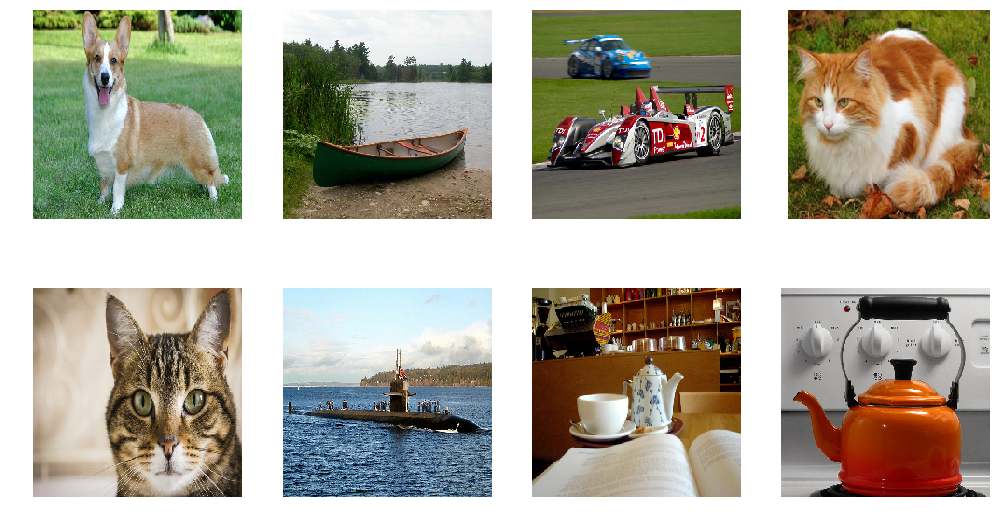

In [144]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
plt.tight_layout()

In [145]:
pictures -= mean
pictures /= std

In [146]:
pred = model.predict(pictures)

In [147]:
np.set_printoptions(linewidth=100, precision=3, suppress=True)

In [148]:
class_names[pred.argsort()[:, 995:]]

array([['toy terrier', 'Cardigan, Cardigan Welsh corgi', 'Chihuahua', 'basenji',
        'Pembroke, Pembroke Welsh corgi'],
       ['barrow, garden cart, lawn cart, wheelbarrow', 'gondola', 'speedboat',
        'paddle, boat paddle', 'canoe'],
       ['crash helmet', 'tow truck, tow car, wrecker', 'sports car, sport car', 'go-kart',
        'racer, race car, racing car'],
       ['Persian cat', 'Pembroke, Pembroke Welsh corgi', 'Pomeranian', 'tabby, tabby cat',
        'tiger cat'],
       ['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
        'lynx, catamount', 'Egyptian cat', 'tiger cat', 'tabby, tabby cat'],
       ['pirate, pirate ship', 'drilling platform, offshore rig', 'dock, dockage, docking facility',
        'wreck', 'submarine, pigboat, sub, U-boat'],
       ['shoe shop, shoe-shop, shoe store', 'dough', 'paper towel',
        'restaurant, eating house, eating place, eatery',
        'toilet tissue, toilet paper, bathroom tissue'],
       ['vase'

In [149]:
np.sort(pred)[:, 995:]

array([[ 0.045,  0.049,  0.104,  0.21 ,  0.567],
       [ 0.   ,  0.001,  0.002,  0.002,  0.994],
       [ 0.   ,  0.001,  0.05 ,  0.101,  0.847],
       [ 0.022,  0.032,  0.043,  0.119,  0.728],
       [ 0.   ,  0.014,  0.14 ,  0.278,  0.568],
       [ 0.012,  0.013,  0.031,  0.153,  0.755],
       [ 0.038,  0.042,  0.061,  0.069,  0.095],
       [ 0.004,  0.023,  0.037,  0.095,  0.839]], dtype=float32)